In [1]:
import sys
sys.path.append('../src')
from ztfanalysis import *
import matplotlib.pyplot as plt
from corner_hack import corner_hack
import numpy as np
import pandas as pd

# use ztfsingle to do fits step by step

### redshift, distance module and milky way ebv is needed

In [2]:
ztfid = 'ZTF19abtsnyy'
ztfm = ztfmultiple(datadir='/Users/yash0613/Library/CloudStorage/Box-Box/ztf_data/',
                   metafile='rcf_query.txt', verbose=True)
ztfm.parse_meta()
ztfm.format_meta()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


meta 142 objs


### show flux and mag plots

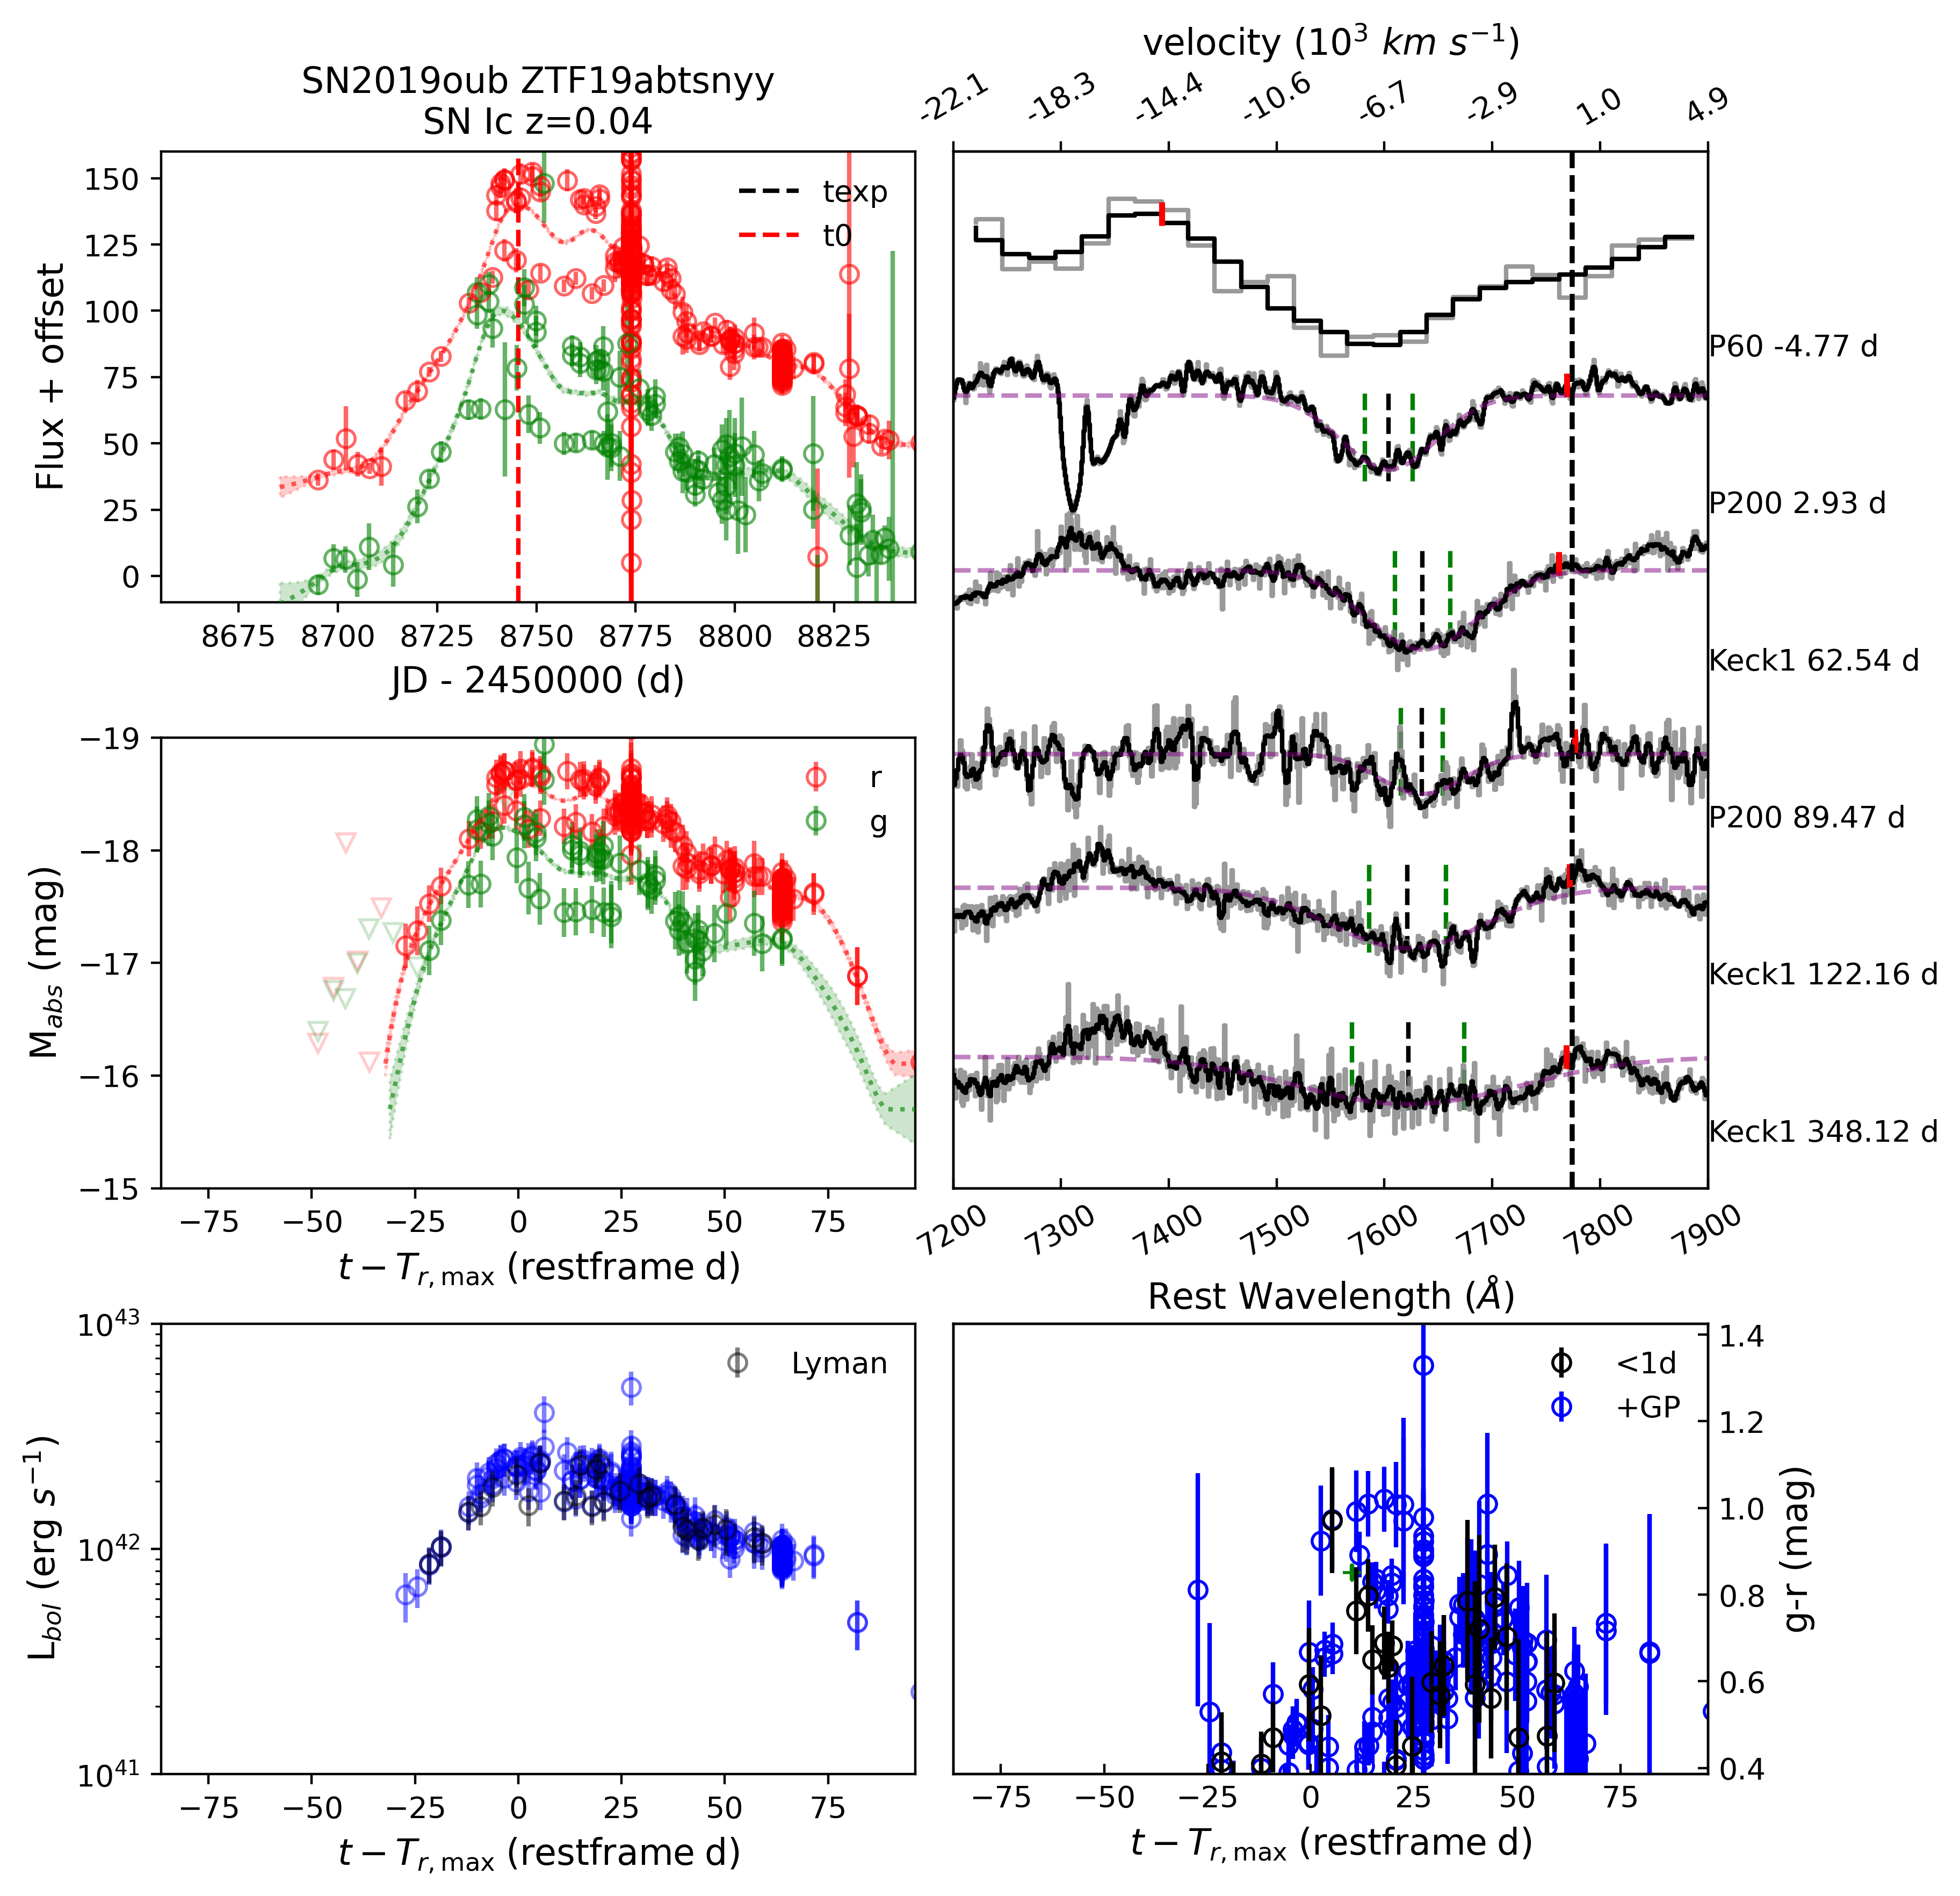

In [65]:
# initialize class
ztfm.parse_params(force=True)
par = dict()
if ztfid in ztfm.params: par = ztfm.params[ztfid]

ztfp = ztfsingle(ztfid=ztfid, iauid=ztfm.meta['IAUID'][ztfid], 
                 z=ztfm.meta['redshift'][ztfid],
                 dm=ztfm.meta['dm'][ztfid],
                 mkwebv=ztfm.meta['ebv'][ztfid],
                 sntype=ztfm.meta['type'][ztfid], **par)

# get forced lightcurves
sigma = 5
df = pd.read_csv('/Users/yash0613/Desktop/%s_fnu.csv'%ztfid,sep=',')
df.rename(columns={'jd':'jdobs',
                   'fnu_microJy':'Fpsf',
                   'fnu_microJy_unc':'Fpsf_unc',
                   'zpdiff':'zp',
                   'sys_unc_factor': 'ezp',
                   'passband': 'filter'}, inplace=True)
        
mags, sigmamags, limmags, filters, frat, efrat = [], [], [], [], [], []
for _ in df.index:
    flux, fluxerr, filtro, zpdiff = df['Fpsf'][_], df['Fpsf_unc'][_], \
                                    df['filter'][_], df['zp'][_]
    snr = flux / fluxerr
    zpdiff = 23.9
    F0 = 10**(zpdiff/2.5)
    Fratio = flux / F0
    eFratio = fluxerr / F0
    if flux > 0 and snr > sigma:
        magpsf = -2.5*np.log10(flux) + zpdiff
        sigmamagpsf = abs(-2.5/np.log(10) * fluxerr / flux)
    else:
        magpsf = 99
        sigmamagpsf = 99
    limmag = -2.5*np.log10(sigma*fluxerr) + zpdiff
    mags.append(magpsf)
    sigmamags.append(sigmamagpsf)
    limmags.append(limmag)
    filters.append(filtro.replace('ZTF_',''))    
    frat.append(Fratio)
    efrat.append(eFratio)
df['mag'] = mags
df['emag'] = sigmamags
df['limmag'] = limmags
df['filter'] = filters
df['Fratio'] = frat
df['Fratio_unc'] = efrat
ztfp.lc = df

ztfp.add_flux()
ztfp.init_fig()
ztfp.on_sntype() # check sn type   
ztfp.run_gp()     # Gaussian process
ztfp.set_t0_withgp()
ztfp.set_texp_midway() # try to set texp    
ztfp.run_fit()   # sn-like analytic functions
ztfp.explosion_pl()  # power law for first light
ztfp.calc_colors()  # g-r colour epochs
ztfp.est_host_c10()   # use g-r compared to tpl for host ebv
ztfp.lyman_bol()  # calculate luminosity from g,r with Lyman bol correction
ztfp.arnett_fit() # fit lums around peak to arnett model
ztfp.tail_fit()   # fit lums at tail to gamma leakage model
ztfp.get_local_spectra()  # obtain local spectra
ztfp.meas_specline()  # measure specific lines, fit photos v to break arnett degenaracy
ztfp.plot()   # plot everything

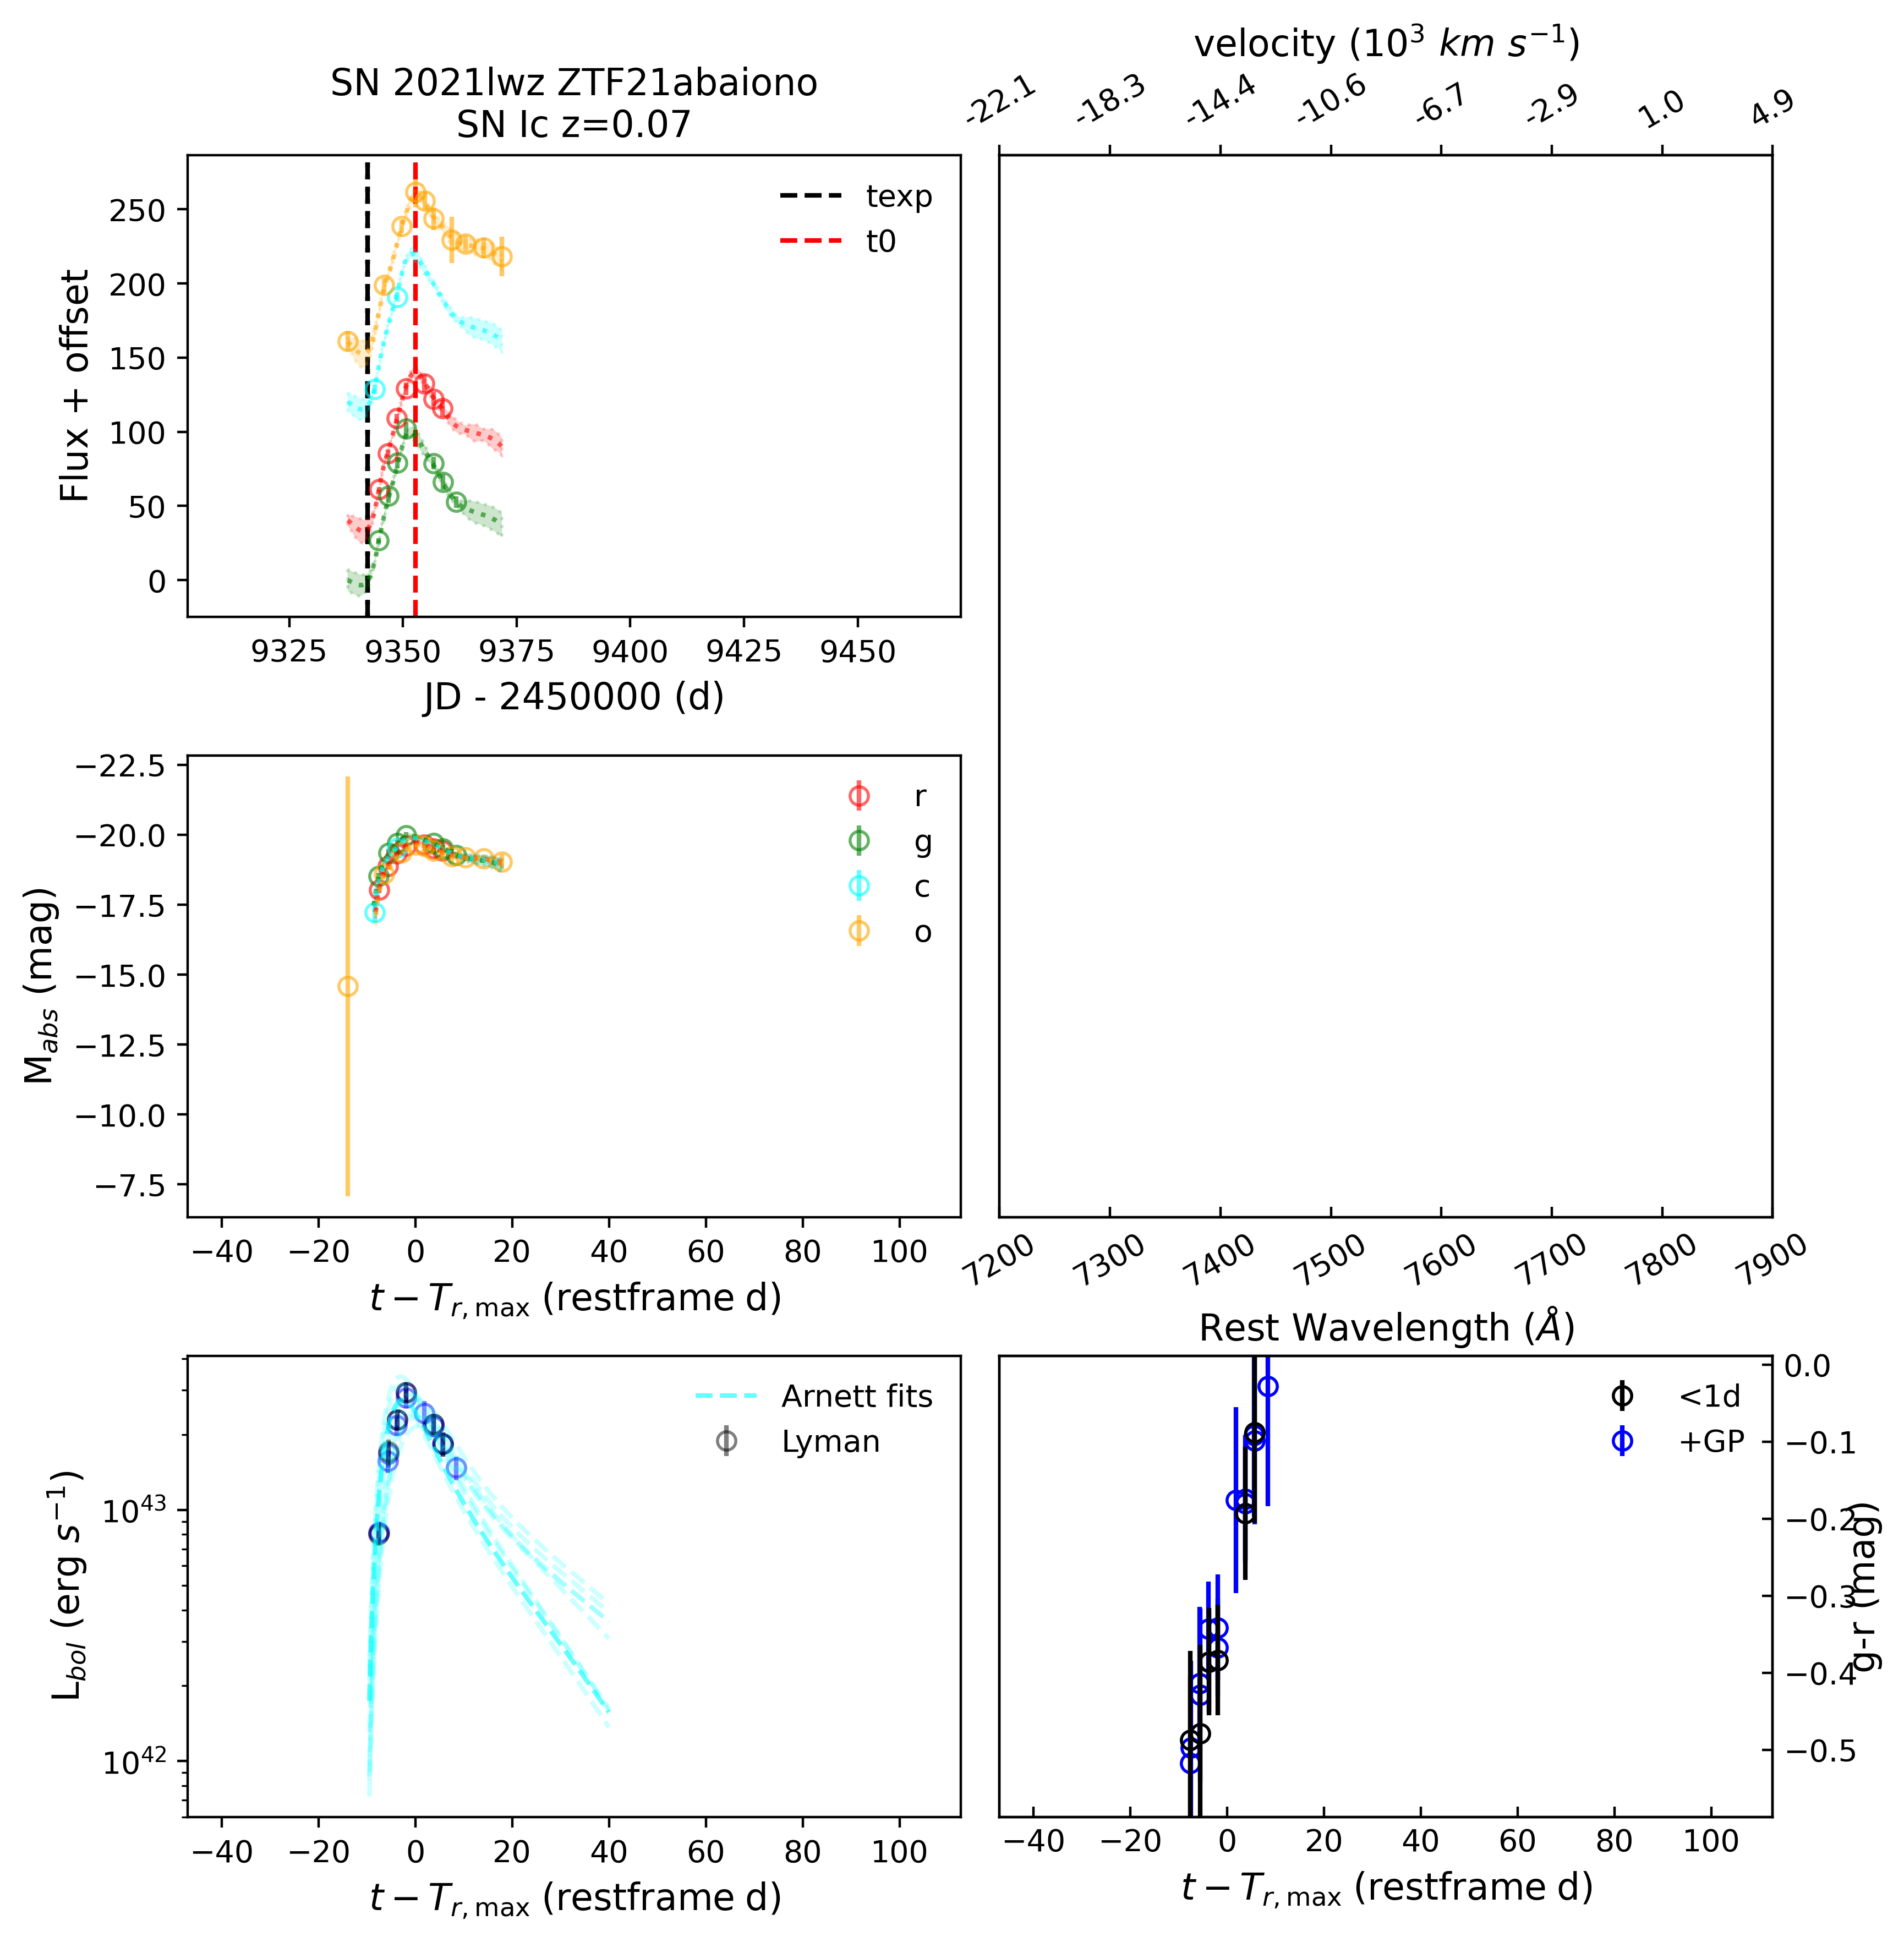

In [15]:
# initialize class
ztfp = ztfsingle(ztfid='ZTF21abaiono', iauid='SN 2021lwz', 
                 z=0.065, dm=37.29, mkwebv=0, sntype='SN Ic')
df = pd.read_csv('/Users/yash0613/Desktop/2021lwz_dat.csv',sep=',')
df.rename(columns={'time':'mjdobs',
                   'magnitude':'mag',
                   'e_magnitude':'emag',
                   'band': 'filter'}, inplace=True)
df['jdobs'] = df['mjdobs'] + 2400000.5
ztfp.lc = df
ztfp.add_flux()
ztfp.init_fig()
ztfp.on_sntype() # check sn type   
ztfp.run_gp()     # Gaussian process
ztfp.set_t0_withgp() 
ztfp.calc_colors()  # g-r colour epochs
ztfp.lyman_bol()  # calculate luminosity from g,r with Lyman bol correction
#ztfp.bb_colors(cfilters=['r','g','c','o'],bolopt=[2],bb_copt=[1,3])
#ztfp.bb_bol(bolopt=[2])
ztfp.arnett_fit() # fit lums around peak to arnett model
ztfp.plot(plot_bands=['r','g','c','o'])   # plot everything

In [23]:
ztfp.arnettcls.get_par()

([0.6986909601240061, 5.372478838438789, -11.399679914326033],
 [0.8410812392537761, 7.3066261329785425, -10.522578362792004],
 [0.9715538606215076, 9.008890735492228, -9.355223412734103])

In [25]:
from models import Arnett_mej_ek_1
Arnett_mej_ek_1(7.30, 25, taumerr=None, vejerr=None)

(1.4786001168713636, 5.514254310857143)

In [18]:
ztfp.fig.savefig('/Users/yash0613/Desktop/2021lwz.png', dpi=400, bbox_inches='tight')

In [12]:
for _ in ztfp.lc.query('Fmcmc_unc>0')['Fmcmc_unc']:print (_)

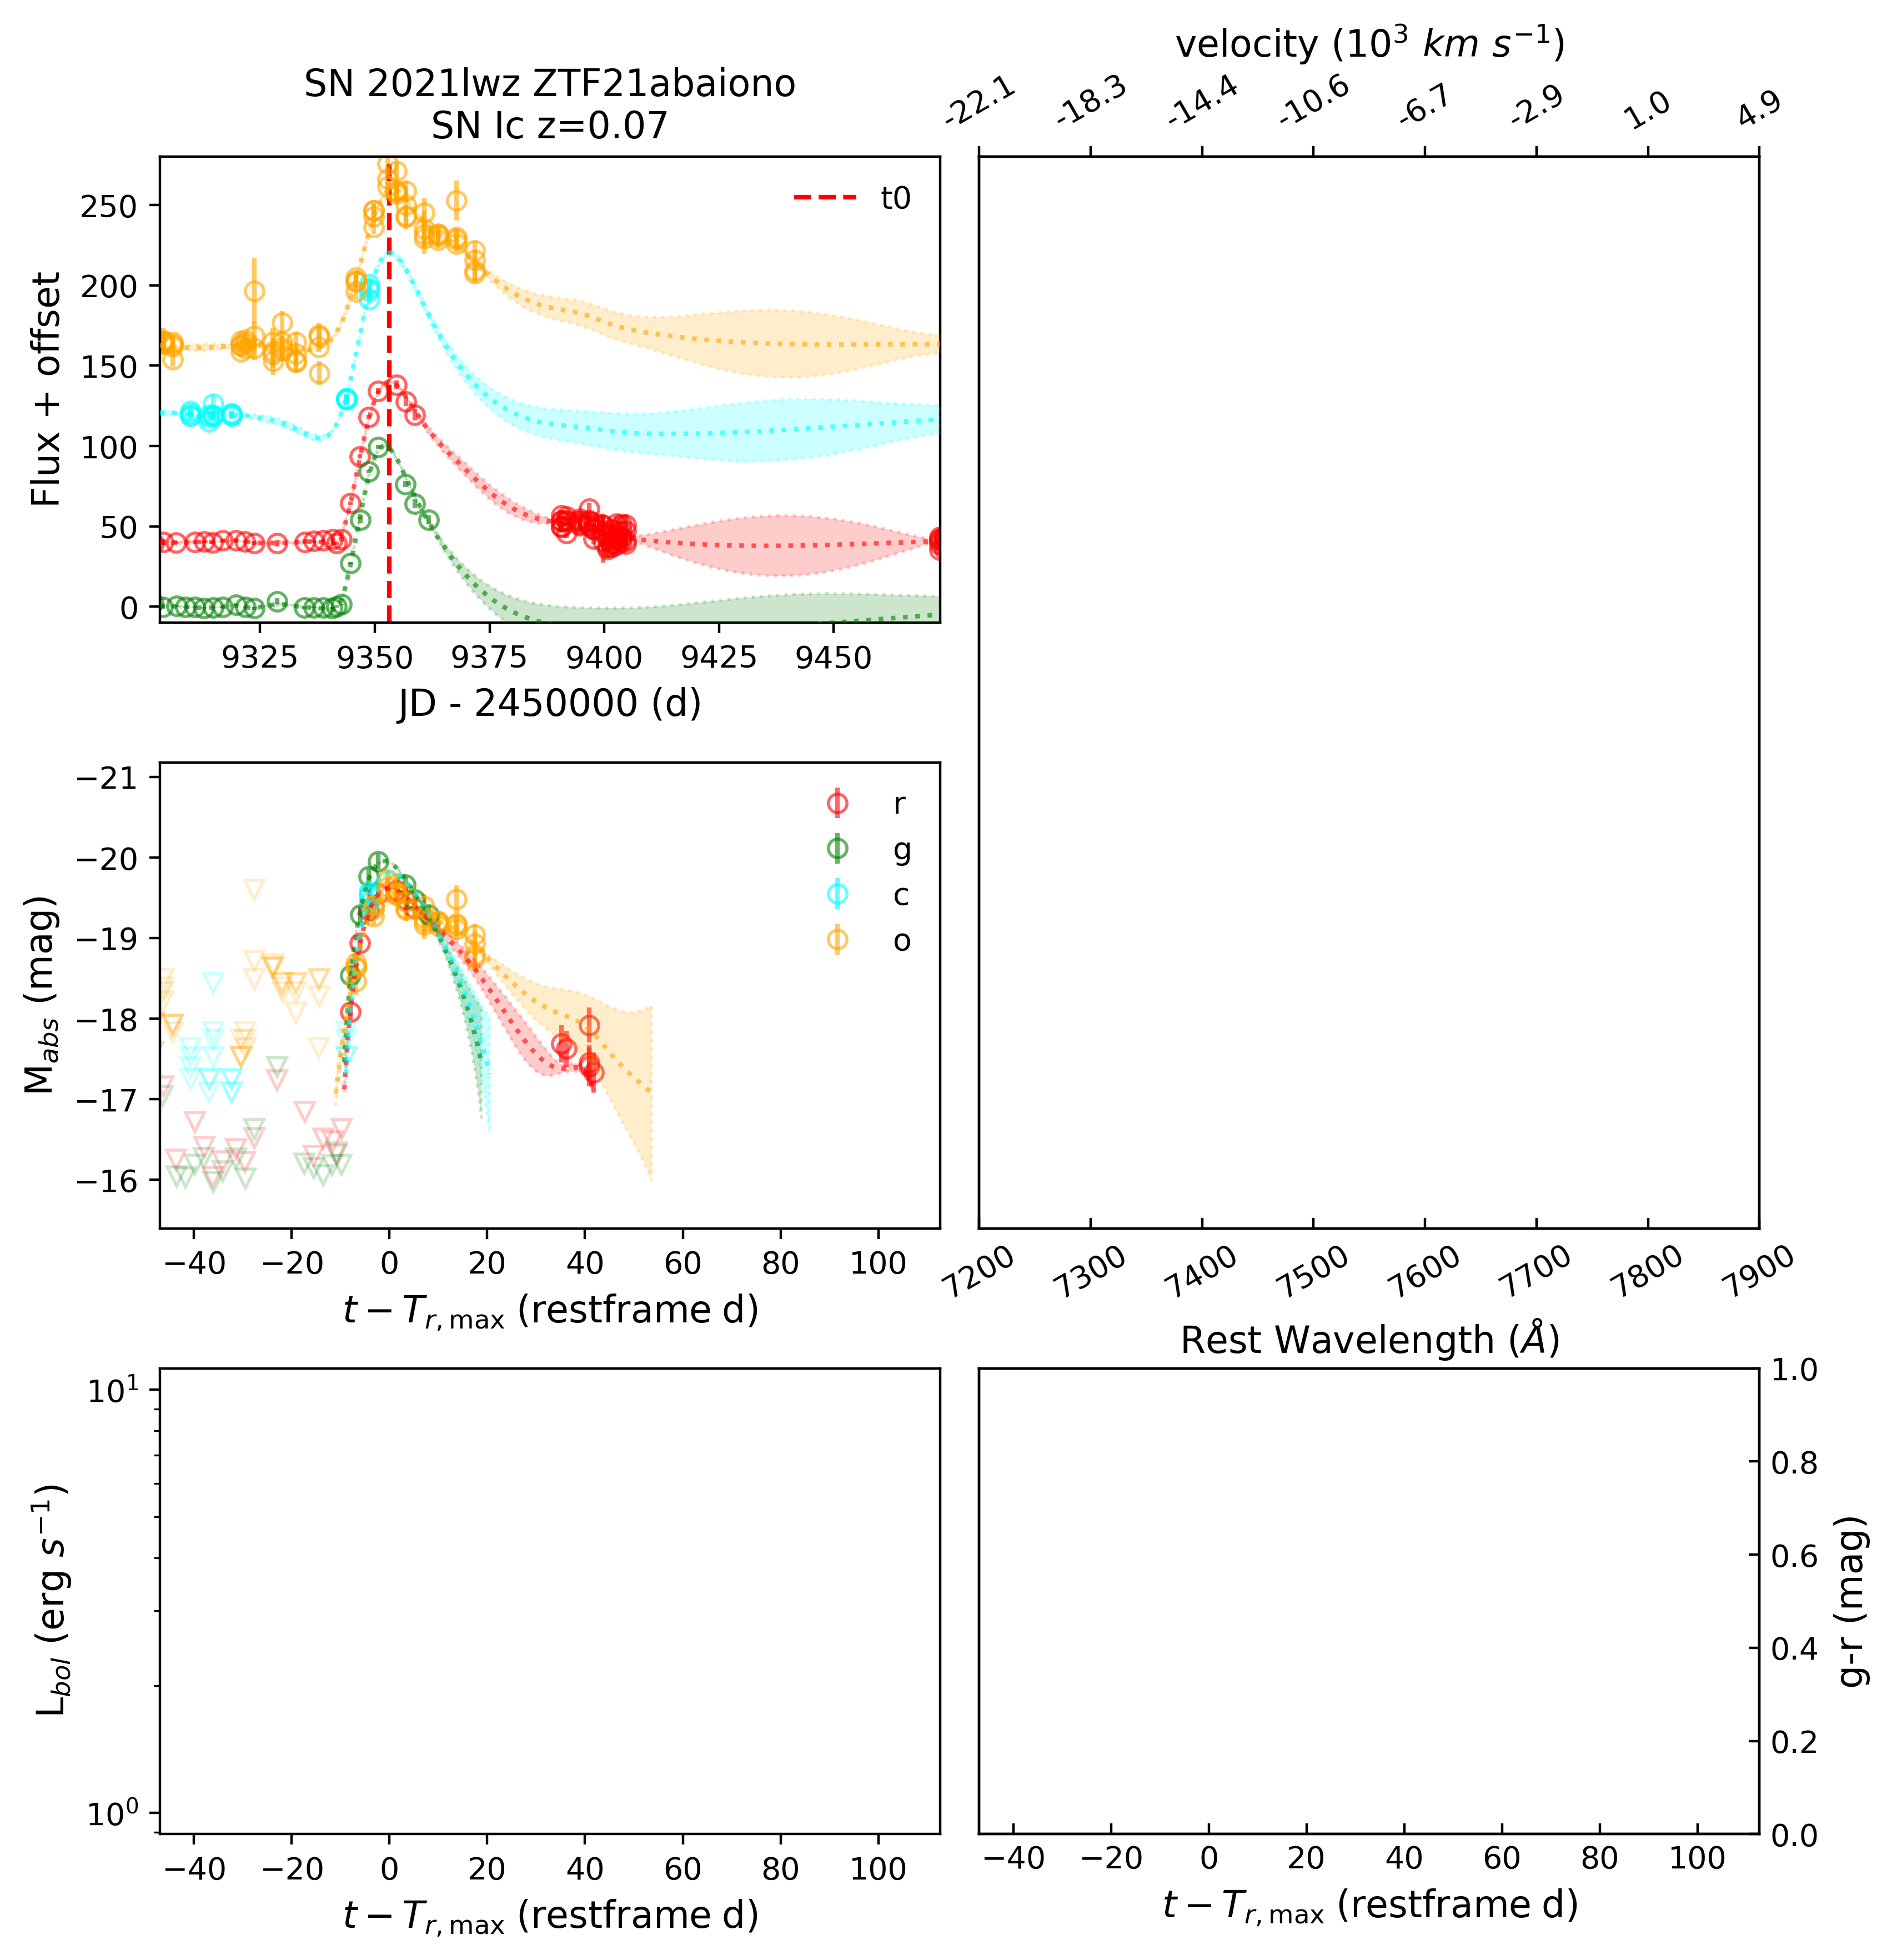

In [50]:
par = {
    'plot_bands': "['r','g','c','o']",
    'plot_bands': "['r','g','c','o']",
    'ax_ylim': "[-10,280]",
}
ztfp = ztfsingle(ztfid='ZTF21abaiono', iauid='SN 2021lwz', 
                 z=0.065, dm=37.29, mkwebv=0, sntype='SN Ic', **par)
ztfp.get_fp_ztf()
ztfp.get_fp_atlas()
#ztfp.lc = ztfp.lc.query('programid==1')
ztfp.add_flux()
ztfp.init_fig()
ztfp.on_sntype() # check sn type   
ztfp.run_gp()     # Gaussian process
ztfp.set_t0_withgp() 
#ztfp.calc_colors()  # g-r colour epochs
#ztfp.lyman_bol()  # calculate luminosity from g,r with Lyman bol correction
#ztfp.arnett_fit() # fit lums around peak to arnett model
ztfp.plot()   # plot everything

In [5]:
ztfp = ztfsingle(ztfid='ZTF21abaiono', iauid='SN 2021lwz', ra='09:44:47.40',
                 dec='+34:42:44.3', z=0.065, dm=37.29, mkwebv=0, sntype='SN Ic')
#ztfp.query_fp_atlas(clobber=True,
#        verbose=True, mjdstart=59250, mjdend=59300)
#ztfp.query_spectra(source=None)
#ztfp.query_alert_ztf(source='fritz')


In [37]:
from collections import OrderedDict
import json, requests
search_obj          = [("ra", ""), ("dec", ""), ("radius", ""), ("units", ""), ("objname", "1998bw"), 
                       ("objname_exact_match", 0), ("internal_name", ""), 
                       ("internal_name_exact_match", 0), ("objid", ""), ("public_timestamp", "")]
get_obj             = [("objname", "1987a"), ("objid", ""), ("photometry", "1"), ("spectra", "1")]
tns_botid = 131335
tns_botname = "kinder_bot"
tns_api = '02c3e6e17237a7fc5ad9825a53cc61f0db360aa4'
TNS         = "sandbox.wis-tns.org"
url_tns_api = "https://" + TNS + "/api/get"
#search_url  = url_tns_api + "/search"
#tns_marker = 'tns_marker{"tns_id": "' + str(tns_botid) + '", "type": "bot", "name": "' + tns_botname + '"}'        
#headers = {'User-Agent': tns_marker}
#json_file = OrderedDict(search_obj)
#search_data = {'api_key': tns_api, 'data': json.dumps(json_file)}
#response = requests.post(search_url, headers = headers, data = search_data)
#parsed = json.loads(response.text, object_pairs_hook = OrderedDict)
#result = json.dumps(parsed, indent = 4)

get_url = url_tns_api + "/object"
tns_marker = 'tns_marker{"tns_id": "' + str(tns_botid) + '", "type": "bot", "name": "' + tns_botname + '"}'
headers = {'User-Agent': tns_marker}
json_file = OrderedDict(get_obj)
get_data = {'api_key': tns_api, 'data': json.dumps(json_file)}
response = requests.post(get_url, headers = headers, data = get_data)
#parsed = json.loads(response.text, object_pairs_hook = OrderedDict)
#result = json.dumps(parsed, indent = 4)
print (response.text)


{"id_code":401,"id_message":"Unauthorized"}
